In [3]:
import pandas as pd
import json
import operator
import re

from ellmer.selfexplainer import SelfExplainer

/Users/tteofili/dev/ellmer/ellmer/selfexplainer.py:535: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if nm is not None and len(ns) is not 0 and len(cf) is not 0:
/Users/tteofili/dev/ellmer/ellmer/selfexplainer.py:535: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if nm is not None and len(ns) is not 0 and len(cf) is not 0:


In [4]:
def token_perturb_for_target_label(row, ranked_cols, predict_fn, label, k):

    row = row.copy()
    top_k = ranked_cols[:k]

    for entry in top_k:
        if "__" not in entry:
            raise ValueError(f"Ranked column entry must be 'attr__token', got: {entry}")

        attr, token = entry.split("__", 1)

        if attr not in row:
            continue

        original_val = str(row[attr])

        counterpart_attr = None
        if attr.startswith("ltable_"):
            counterpart_attr = "rtable_" + attr[len("ltable_"):]
        elif attr.startswith("rtable_"):
            counterpart_attr = "ltable_" + attr[len("rtable_"):]

        if label == 1:
            # remove the token from the attribute
            pattern = re.escape(token)
            new_val = re.sub(pattern, "", original_val, flags=re.IGNORECASE)

            # clean double spaces left behind
            new_val = re.sub(r"\s+", " ", new_val).strip()
            row[attr] = new_val

        else:
            # make token equal to the counterpart’s value or its matching token
            if counterpart_attr in row:
                counterpart_val = str(row[counterpart_attr])

                # if counterpart contains the same token, force-copy only that token
                if re.search(re.escape(token), counterpart_val, flags=re.IGNORECASE):
                    replacement = token
                else:
                    # replace token with the *whole counterpart attribute* (fallback)
                    replacement = counterpart_val

                pattern = re.escape(token)
                new_val = re.sub(pattern, replacement, original_val, flags=re.IGNORECASE)

                row[attr] = new_val

    new_pred = predict_fn(row)
    return row, new_pred


In [5]:
llm = SelfExplainer(explanation_granularity='attribute',
                                 temperature=1,
                                 model_name='gpt-5-nano', model_type='azure_openai',
                                 prompts={"ptse": {"er": "../ellmer/prompts/er.txt"}})

/Users/tteofili/dev/ellmer/ellmer/selfexplainer.py:38: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  self.llm = AzureChatOpenAI(model_name=model_name, request_timeout=120,


In [6]:
def predict_fn(row):
    return llm.predict(pd.DataFrame(row))['match_score'].values[0]


In [46]:
with open("/Users/tteofili/dev/ellmer/experiments/azure_openai/gpt-5-nano/token/beers/20251204/14_51/0_results.json") as f:
    d = json.load(f)

In [47]:
ltuple = pd.json_normalize(d['data'][0]['cot_sample']['ltuple']).add_prefix('ltable_')
rtuple = pd.json_normalize(d['data'][0]['cot_sample']['rtuple']).add_prefix('rtable_')

In [48]:
beers_row = pd.concat([ltuple, rtuple], axis=1)
beers_row

,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV
0,Bulleit Bourbon Barrel Aged G'Knight,Oskar Blues Grill & Brew,American Amber / Red Ale,8.70 %,Figure Eight Bourbon Barrel Aged Jumbo Love,Figure Eight Brewing,Barley Wine,-


In [49]:
prediction = pd.json_normalize(d['data'][0]['cot_sample'])['prediction']
prediction

0    0
Name: prediction, dtype: int64

In [50]:
self_explanation = pd.json_normalize(d['data'][0]['cot_sample']['saliency'])
self_explanation

,ltable_Beer_Name__Bulleit,ltable_Beer_Name__Bourbon,ltable_Beer_Name__Barrel,ltable_Beer_Name__Aged,ltable_Beer_Name__G'Knight,ltable_Brew_Factory_Name__Oskar,ltable_Brew_Factory_Name__Blues,ltable_Brew_Factory_Name__Grill,ltable_Brew_Factory_Name__&,ltable_Brew_Factory_Name__Brew,...,rtable_Beer_Name__Barrel,rtable_Beer_Name__Aged,rtable_Beer_Name__Jumbo,rtable_Beer_Name__Love,rtable_Brew_Factory_Name__Figure,rtable_Brew_Factory_Name__Eight,rtable_Brew_Factory_Name__Brewing,rtable_Style__Barley,rtable_Style__Wine,rtable_ABV__-
0,0.7,0.25,0.2,0.15,0.65,0.05,0.05,0.05,0.05,0.05,...,0.2,0.18,0.76,0.64,0.5,0.5,0.6,0.6,0.55,0.1


In [51]:
post_hoc_explanation = pd.json_normalize(d['data'][0]['certa_sample']['saliency'])
post_hoc_explanation

,ltable_Brew_Factory_Name__Blues,ltable_Beer_Name__G'Knight,ltable_ABV__8.70,ltable_Beer_Name__Bulleit,ltable_Brew_Factory_Name__&,ltable_Brew_Factory_Name__Oskar,ltable_Style__/,ltable_Style__Amber,ltable_Beer_Name__Aged,ltable_Beer_Name__Barrel,...,rtable_Beer_Name__Eight,rtable_Beer_Name__Figure,rtable_Style__Barley,rtable_Beer_Name__Love,rtable_Brew_Factory_Name__Figure,rtable_Beer_Name__Bourbon,rtable_Beer_Name__Barrel,rtable_Brew_Factory_Name__Brewing,ltable_Style__American,ltable_ABV__%
0,0.590909,0.636364,0.636364,0.681818,0.681818,0.681818,0.681818,0.681818,0.545455,0.590909,...,0.318182,0.318182,0.318182,0.272727,0.318182,0.318182,0.318182,0.318182,0.590909,0.590909


In [52]:
# compare
explanations = pd.concat([self_explanation, post_hoc_explanation], axis=0, keys=['self', 'post_hoc'])
explanations.head()

,,ltable_Beer_Name__Bulleit,ltable_Beer_Name__Bourbon,ltable_Beer_Name__Barrel,ltable_Beer_Name__Aged,ltable_Beer_Name__G'Knight,ltable_Brew_Factory_Name__Oskar,ltable_Brew_Factory_Name__Blues,ltable_Brew_Factory_Name__Grill,ltable_Brew_Factory_Name__&,ltable_Brew_Factory_Name__Brew,...,rtable_Beer_Name__Aged,rtable_Beer_Name__Jumbo,rtable_Beer_Name__Love,rtable_Brew_Factory_Name__Figure,rtable_Brew_Factory_Name__Eight,rtable_Brew_Factory_Name__Brewing,rtable_Style__Barley,rtable_Style__Wine,rtable_ABV__-,ltable_Style__/
self,0,0.700000,0.250000,0.200000,0.150000,0.650000,0.050000,0.050000,0.05,0.050000,0.05,...,0.180000,0.760000,0.640000,0.500000,0.500000,0.600000,0.600000,0.550000,0.100000,NaN
post_hoc,0,0.681818,0.681818,0.590909,0.545455,0.636364,0.681818,0.590909,0.50,0.681818,NaN,...,0.318182,0.272727,0.272727,0.318182,0.318182,0.318182,0.318182,0.318182,0.318182,0.681818


<Axes: >

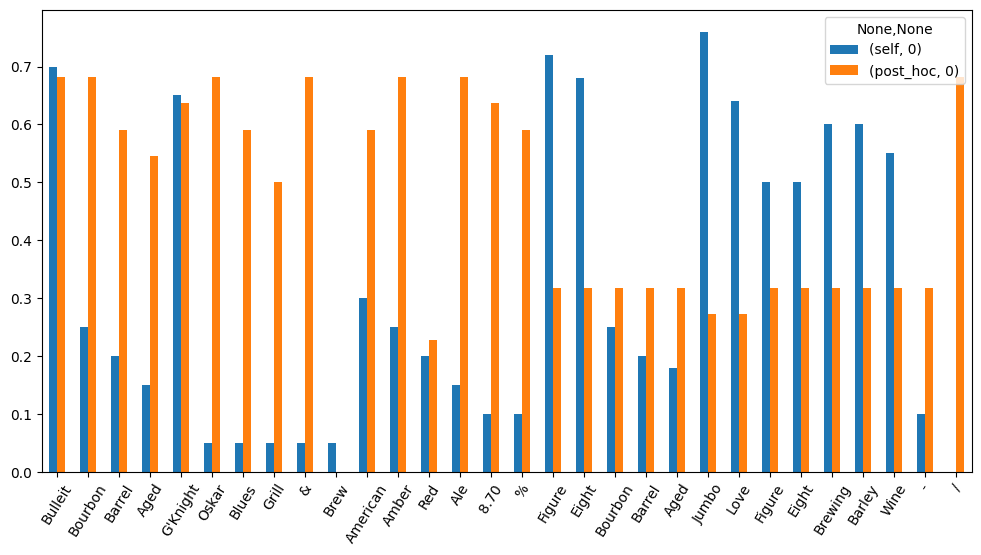

In [60]:
explanations_viz = explanations.copy()
explanations_viz.columns = explanations.columns.str.split('__').str[-1]
explanations_viz.T.plot(kind='bar', stacked=False, figsize=(12, 6), rot=58)

In [56]:
k_range = 6
res = []

for i in range(len(explanations)):
    expl = explanations.iloc[i]
    explainer = expl.name[0]
    salient_features = [r[0] for r in sorted(expl.to_dict().items(), key=operator.itemgetter(1), reverse=True)]
    for k in range(k_range):
        pert, pred = token_perturb_for_target_label(beers_row, salient_features, predict_fn, label=int(prediction.values), k=k)
        cr = {'prediction': pred, 'perturbed': pert, 'explainer': explainer}
        res.append(cr)

consistency = pd.DataFrame(res)


/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_9919/1240791563.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pert, pred = token_perturb_for_target_label(beers_row, salient_features, predict_fn, label=int(prediction.values), k=k)
100%|██████████| 1/1 [00:02<00:00,  2.11s/it]
/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_9919/1240791563.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pert, pred = token_perturb_for_target_label(beers_row, salient_features, predict_fn, label=int(prediction.values), k=k)
100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
/var/folders/mr/6xnd0hrs6257283btx8ff88r0000gn/T/ipykernel_9

In [57]:
consistency[['explainer','prediction']].groupby(['explainer']).sum()/k_range

,prediction
explainer,
post_hoc,0.333333
self,0.000000
